In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import mean
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, BaggingClassifier,GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
import tensorflow as tf
record = pd.read_csv("credit_record.csv")
apl = pd.read_csv('application_record.csv')


In [ ]:
#data cleansing:
def label(x):
    if x >= 2:
        return 'RISKY'
    else:
        return 'SAFE'

def day_age(x):
    year = -x//365
    return year

apl_v1 = apl[apl.DAYS_EMPLOYED < 0]
apl_v2 = apl_v1.dropna()
apl_v3 = apl_v2.drop(columns='FLAG_MOBIL')
record.STATUS.replace({'C': -1, 'X': -2}, inplace=True)
record.STATUS = record.STATUS.astype('int')
record1 = record.groupby('ID')['STATUS'].max().to_frame()

record1['label'] = record1.STATUS.apply(label)
apl_v4 = apl_v3.merge(record1['label'], how='inner', on='ID')
apl_v4[['DAYS_BIRTH', 'DAYS_EMPLOYED']] = apl_v4[[
    'DAYS_BIRTH', 'DAYS_EMPLOYED']].apply(day_age)
apl_v4.rename(columns={'DAYS_BIRTH': 'Age',
              'DAYS_EMPLOYED': 'employeed_years'}, inplace=True)
apl_v4.drop('ID', axis=1, inplace=True)

apl_v4['label'] = apl_v4['label'].replace({'SAFE': 0, 'RISKY': 1})
data = apl_v4.drop(columns='label')
label = apl_v4.label


In [ ]:
#data type conversion
numerical_columns = selector(dtype_exclude=object)
categorical_columns = selector(dtype_include=object)

numerical_columns = numerical_columns(data)
categorical_columns = categorical_columns(data)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])


In [ ]:
#build models
model1 = make_pipeline(preprocessor, LogisticRegression())
model2 = make_pipeline(preprocessor, HistGradientBoostingClassifier())
model3 = make_pipeline(preprocessor, SVC())
model4 = make_pipeline(preprocessor, RandomForestClassifier())

In [ ]:
#separate the data into training and testing set and train machine learning models
data_train, data_test, label_train, label_test = train_test_split(
    data, label)
model1.fit(data_train,label_train)
model2.fit(data_train,label_train)
model3.fit(data_train,label_train)
model4.fit(data_train,label_train)

model1_fit=model1.predict(data_test)
model2_fit=model2.predict(data_test)
model3_fit=model3.predict(data_test)
model4_fit=model4.predict(data_test)
#print out accuracy for test dataset
print(accuracy_score(label_test,model1_fit))
print(accuracy_score(label_test,model2_fit))
print(accuracy_score(label_test,model3_fit))
print(accuracy_score(label_test,model4_fit))

c:\Users\ken77\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.98026734563972
0.9801082113303629
0.9799490770210058
0.9809038828771484


[0 1]
0.98026734563972
[0 1]
0.9801082113303629
[0]
0.9799490770210058
[0 1]
0.9809038828771484


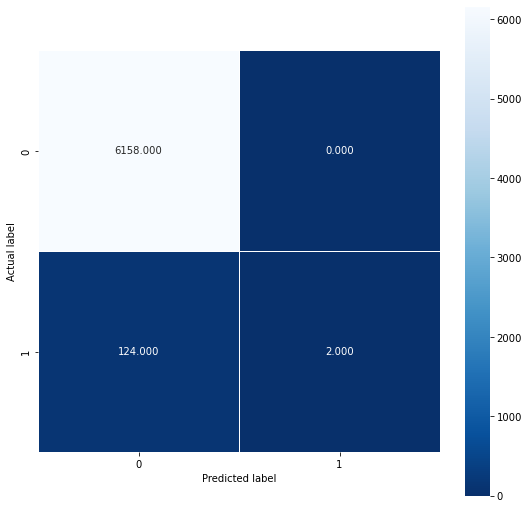

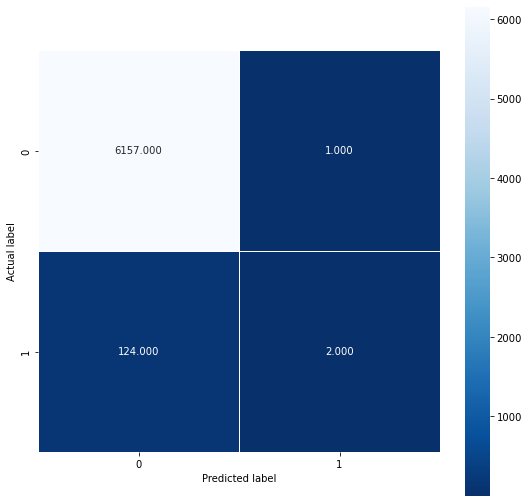

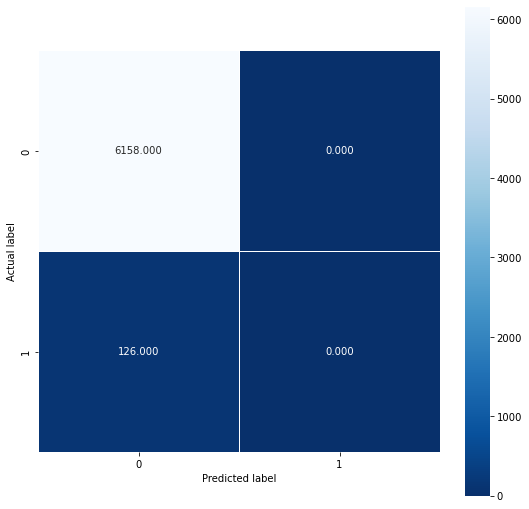

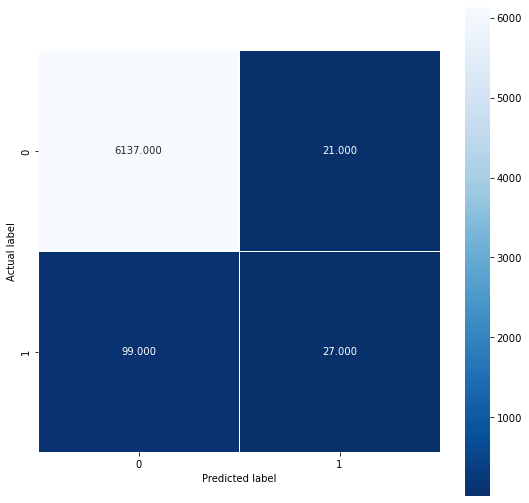

In [ ]:
# heat map with accuracy:
def heat(model, label_train, data_train):
    pred_y_4 = model.predict(data_train)
    x = confusion_matrix(label_train, pred_y_4)
    plt.figure(figsize=(9, 9))
    sns.heatmap(x, annot=True, fmt=".3f", linewidths=.5,
                square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    print(np.unique(pred_y_4))
    print(accuracy_score(label_train, pred_y_4))

heat(model1, label_test, data_test)
heat(model2, label_test, data_test)
heat(model3, label_test, data_test)
heat(model4, label_test, data_test)

In [ ]:
#use f2 score, since the model focuses more on recall rate than precision rate
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

In [ ]:
def roc_pr(model):
    fig = plt.figure(figsize=(24, 8))
    ax1 = fig.add_subplot(1, 3, 1)

    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('PR Curve')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.plot([0, 1], [0, 1], '--', label='No Skill')
    f2_scores = []
    recall_scores = []
    precision_scores = []
    weights = [1, 10, 20,30, 50, 100]
    for weight in weights:
        modelw = make_pipeline(preprocessor, model(
            class_weight={0: 1.5, 1: weight}))
        modelw.fit(data_train, label_train)
        pred_prob = modelw.predict_proba(data_test)[:, 1]
        precision, recall, thresholds = precision_recall_curve(
            label_test, pred_prob)
        tpr, fpr, thresholds = roc_curve(label_test, pred_prob)

        ax1.plot(recall, precision, label=weight)
        ax2.plot(tpr, fpr, label=weight)

        pred = modelw.predict(data_test)
        f2_test = f2_score(label_test, pred)
        recall_test = recall_score(label_test, pred)
        precision_test = precision_score(label_test, pred)
        f2_scores.append(f2_test)
        recall_scores.append(recall_test)
        precision_scores.append(precision_test)

    ax1.legend(loc='lower left')
    ax2.legend(loc='lower right')

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.set_title('Precision_recall_F2 Bar Plot')
    w = 0.3
    pos = np.arange(len(precision_scores))
    b1 = ax3.bar(pos, precision_scores, w, color='deepskyblue')
    b2 = ax3.bar(pos + w, recall_scores, w, color='indigo')
    b3 = ax3.bar(pos + (2*w), f2_scores, w, color='crimson')

    ax3.set_xticks(pos + w)
    ax3.set_xticklabels(weights)
    ax3.set_ylabel('score')
    ax3.set_xlabel('positive weights')
    ax3.legend(handles=[b1, b2, b3], labels=['precision', 'recall', 'f2'])
    plt.tight_layout()
    plt.style.use('ggplot')
    plt.show()

c:\Users\ken77\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ken77\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

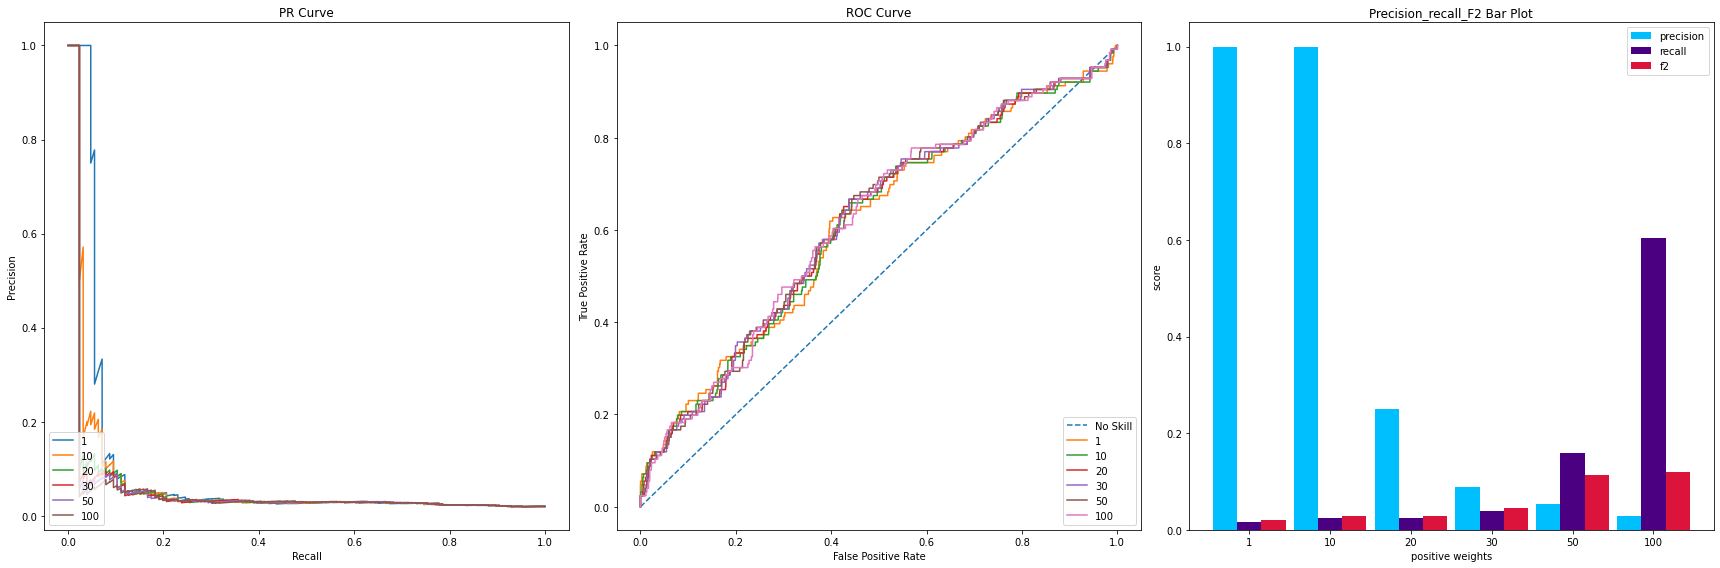

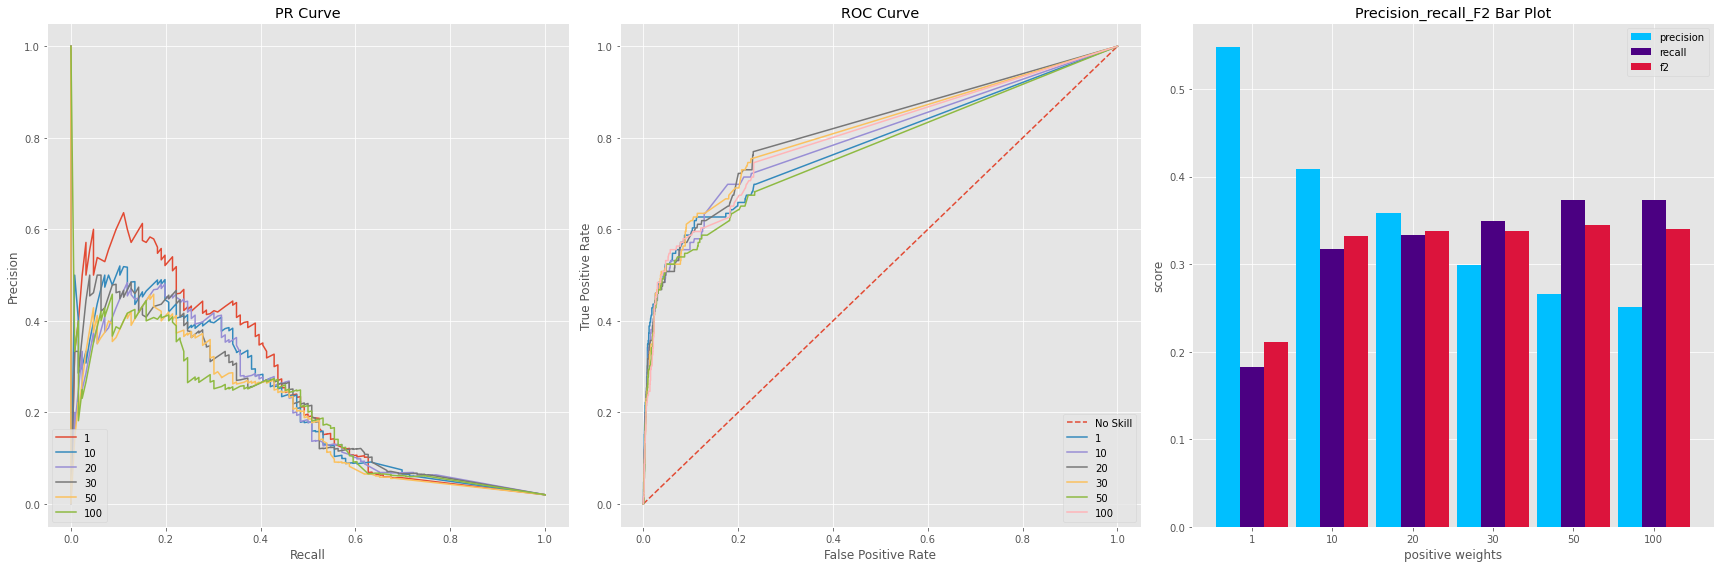

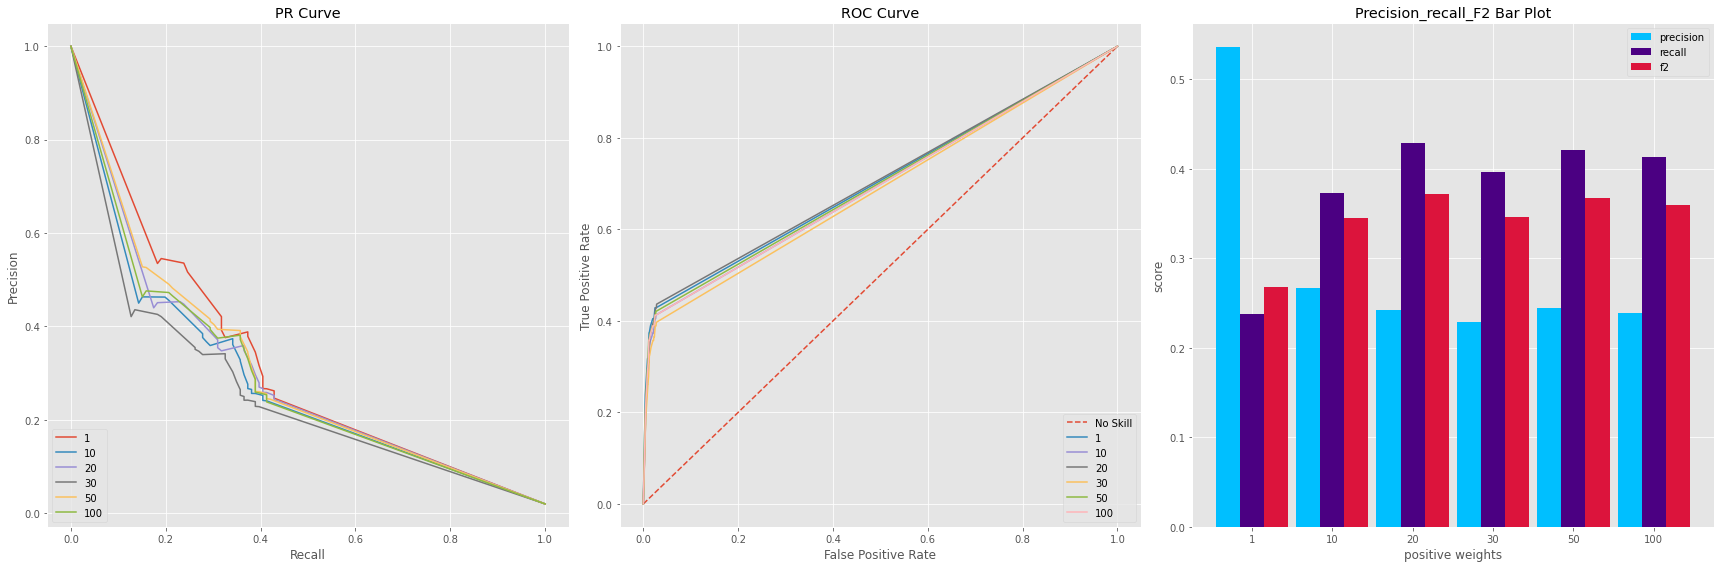

In [ ]:
#print pr_roc_bar plot with the function
roc_pr(LogisticRegression)
roc_pr(RandomForestClassifier)
roc_pr(DecisionTreeClassifier)

In [ ]:
#create train test data for deep learning model
X = preprocessor.fit_transform(data)
y = label
trainX, testX, trainy, testy = train_test_split(
    X, y, random_state=42)

In [ ]:
def define_model(n_input):
    model = Sequential()
    model.add(Dense(20, input_dim=n_input, activation='relu',
                    kernel_initializer='he_uniform'))
    model.add(Dense(20, input_dim=n_input, activation='relu',
                    kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(20, input_dim=n_input, activation='relu',
                    kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='sgd',metrics=['accuracy'])
    return model


In [ ]:
fig = plt.figure(figsize=(24, 8))
f2_scores = []
recall_scores = []
precision_scores = []
weights = [1,10,20,30,50,100,150,200]
for weight in weights:
    n_input = trainX.shape[1]
    model_m = define_model(n_input)
    model_m.fit(trainX, trainy,validation_split=0.1, class_weight={0:1,1:weight}, epochs=400)

    yhat = model_m.predict(testX)
    yhat1 = np.where(yhat > 0.5, 1, 0)
    f2_test = f2_score(testy, yhat1)
    recall_test = recall_score(testy, yhat1)
    precision_test = precision_score(testy, yhat1)
    f2_scores.append(f2_test)
    recall_scores.append(recall_test)
    precision_scores.append(precision_test)

Epoch 1/400
531/531 [==============================] - 1s 1ms/step - loss: 0.1682 - accuracy: 0.9586 - val_loss: 0.0875 - val_accuracy: 0.9841
Epoch 2/400
531/531 [==============================] - 1s 1ms/step - loss: 0.0987 - accuracy: 0.9830 - val_loss: 0.0861 - val_accuracy: 0.9841
Epoch 3/400
531/531 [==============================] - 1s 1ms/step - loss: 0.0963 - accuracy: 0.9830 - val_loss: 0.0852 - val_accuracy: 0.9841
Epoch 4/400
531/531 [==============================] - 1s 1ms/step - loss: 0.0932 - accuracy: 0.9830 - val_loss: 0.0843 - val_accuracy: 0.9841
Epoch 5/400
531/531 [==============================] - 1s 1ms/step - loss: 0.0933 - accuracy: 0.9830 - val_loss: 0.0837 - val_accuracy: 0.9841
Epoch 6/400
531/531 [==============================] - 1s 992us/step - loss: 0.0924 - accuracy: 0.9830 - val_loss: 0.0833 - val_accuracy: 0.9841
Epoch 7/400
531/531 [==============================] - 1s 1ms/step - loss: 0.0919 - accuracy: 0.9830 - val_loss: 0.0830 - val_accuracy: 0.98

<Figure size 1728x576 with 0 Axes>

Epoch 1/400
531/531 [==============================] - 1s 1ms/step - loss: 1.0717 - binary_accuracy: 0.8651 - val_loss: 0.4054 - val_binary_accuracy: 0.9782
Epoch 2/400
531/531 [==============================] - 1s 1ms/step - loss: 1.0315 - binary_accuracy: 0.9499 - val_loss: 0.4556 - val_binary_accuracy: 0.9676
Epoch 3/400
531/531 [==============================] - 1s 1ms/step - loss: 1.0168 - binary_accuracy: 0.9268 - val_loss: 0.4715 - val_binary_accuracy: 0.9538
Epoch 4/400
531/531 [==============================] - 1s 1ms/step - loss: 1.0080 - binary_accuracy: 0.9192 - val_loss: 0.4381 - val_binary_accuracy: 0.9480
Epoch 5/400
531/531 [==============================] - 1s 1ms/step - loss: 1.0052 - binary_accuracy: 0.9065 - val_loss: 0.4589 - val_binary_accuracy: 0.9342
Epoch 6/400
531/531 [==============================] - 1s 992us/step - loss: 0.9876 - binary_accuracy: 0.8999 - val_loss: 0.4258 - val_binary_accuracy: 0.9236
Epoch 7/400
531/531 [==============================] - 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


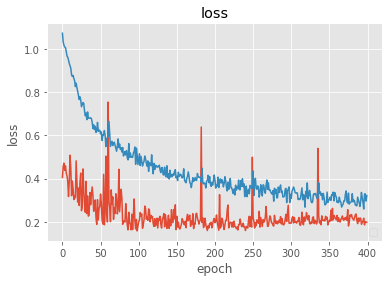

197/197 [==============================] - 0s 600us/step
ROC AUC: 0.668


In [ ]:
n_input = trainX.shape[1]
model_n = Sequential()
model_n.add(Dense(20, input_dim=n_input, activation='relu',
                kernel_initializer='he_uniform'))
model_n.add(Dense(20, input_dim=n_input, activation='relu',
                kernel_initializer='he_uniform'))
model_n.add(Dropout(0.2))
model_n.add(Dense(20, input_dim=n_input, activation='relu',
                kernel_initializer='he_uniform'))
model_n.add(Dense(1, activation='sigmoid'))
model_n.compile(loss='binary_crossentropy', optimizer='sgd',metrics=['binary_accuracy'])
history = model_n.fit(trainX, trainy,validation_split=0.1, epochs=400,class_weight={0:1,1:35})
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')
plt.show()
yhat = model_n.predict(testX)
score = roc_auc_score(testy, yhat)
print('ROC AUC: %.3f' % score)

In [ ]:
fig = plt.figure(figsize=(24, 8))
f2_scores = []
recall_scores = []
precision_scores = []
n_input = trainX.shape[1]

model_n = Sequential()
model_n.add(Dense(20, input_dim=n_input, activation='relu',
                kernel_initializer='he_uniform'))

model_n.add(Dense(20, input_dim=n_input, activation='relu',
                kernel_initializer='he_uniform'))
model_n.add(Dropout(0.2))
model_n.add(Dense(20, input_dim=n_input, activation='relu',
                kernel_initializer='he_uniform'))
model_n.add(Dense(1, activation='sigmoid'))
model_n.compile(loss='binary_crossentropy', optimizer='sgd',metrics=['binary_accuracy'])
model_n.fit(trainX, trainy,validation_split=0.1, epochs=400,batch_size=5,class_weight={0:1,1:30})
yhat = model_n.predict(testX)
yhat1 = np.where(yhat > 0.5, 1, 0)
f2_test = f2_score(testy, yhat1)
recall_test = recall_score(testy, yhat1)
precision_test = precision_score(testy, yhat1)
f2_scores.append(f2_test)
recall_scores.append(recall_test)
precision_scores.append(precision_test)
print(f2_scores,recall_scores,precision_scores)

Epoch 1/400
3393/3393 [==============================] - 4s 1ms/step - loss: 0.9726 - binary_accuracy: 0.9378 - val_loss: 0.4204 - val_binary_accuracy: 0.9772
Epoch 2/400
3393/3393 [==============================] - 3s 903us/step - loss: 0.9309 - binary_accuracy: 0.9482 - val_loss: 0.3570 - val_binary_accuracy: 0.9729
Epoch 3/400
3393/3393 [==============================] - 3s 885us/step - loss: 0.9165 - binary_accuracy: 0.9279 - val_loss: 0.3732 - val_binary_accuracy: 0.9549
Epoch 4/400
3393/3393 [==============================] - 3s 892us/step - loss: 0.9046 - binary_accuracy: 0.9413 - val_loss: 0.4068 - val_binary_accuracy: 0.9687
Epoch 5/400
3393/3393 [==============================] - 3s 890us/step - loss: 0.8922 - binary_accuracy: 0.9227 - val_loss: 0.4298 - val_binary_accuracy: 0.9310
Epoch 6/400
3393/3393 [==============================] - 3s 894us/step - loss: 0.8668 - binary_accuracy: 0.9241 - val_loss: 0.4508 - val_binary_accuracy: 0.8727
Epoch 7/400
3393/3393 [=============

<Figure size 1728x576 with 0 Axes>

[0 1]
0.8718968809675366


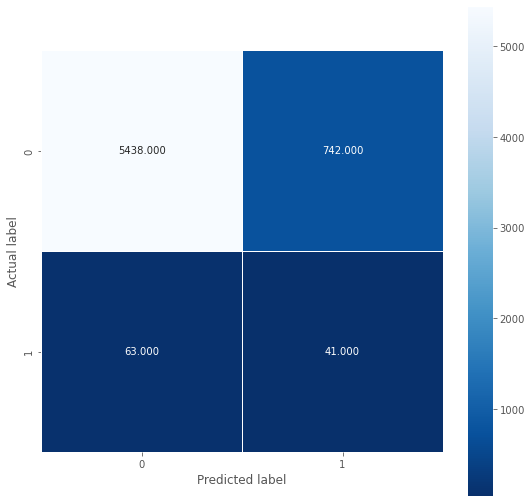

In [ ]:
x = confusion_matrix(testy, yhat1)
plt.figure(figsize=(9, 9))
sns.heatmap(x, annot=True, fmt=".3f", linewidths=.5,
            square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print(np.unique(yhat1))
print(accuracy_score(testy, yhat1))

In [ ]:
n_input = trainX.shape[1]
model_m = Sequential()
model_m.add(Dense(20, input_dim=n_input, activation='relu',
                kernel_initializer='he_uniform'))
model_m.add(Dense(20, input_dim=n_input, activation='relu',
                kernel_initializer='he_uniform'))
model_m.add(Dropout(0.2))
model_m.add(Dense(20, input_dim=n_input, activation='relu',
                kernel_initializer='he_uniform'))
model_m.add(Dense(1, activation='sigmoid'))
model_m.compile(loss='binary_crossentropy', optimizer='sgd',metrics=['binary_accuracy'])
history = model_m.fit(trainX, trainy,validation_split=0.1, epochs=400,class_weight={0:1,1:35})
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')
plt.show()
yhat2 = model_m.predict(testX)
score = roc_auc_score(testy, yhat2)
print('ROC AUC: %.3f' % score)

Epoch 1/400
531/531 [==============================] - 1s 1ms/step - loss: 1.0651 - binary_accuracy: 0.9606 - val_loss: 0.4990 - val_binary_accuracy: 0.9825
Epoch 2/400
531/531 [==============================] - 1s 1ms/step - loss: 1.0366 - binary_accuracy: 0.9687 - val_loss: 0.4189 - val_binary_accuracy: 0.9841
Epoch 3/400
531/531 [==============================] - 1s 1ms/step - loss: 1.0316 - binary_accuracy: 0.9782 - val_loss: 0.4705 - val_binary_accuracy: 0.9841
Epoch 4/400
531/531 [==============================] - 1s 1ms/step - loss: 1.0183 - binary_accuracy: 0.9761 - val_loss: 0.4734 - val_binary_accuracy: 0.9841
Epoch 5/400
531/531 [==============================] - 1s 1ms/step - loss: 1.0060 - binary_accuracy: 0.9635 - val_loss: 0.4863 - val_binary_accuracy: 0.9809
Epoch 6/400
531/531 [==============================] - 1s 1ms/step - loss: 0.9979 - binary_accuracy: 0.9548 - val_loss: 0.5169 - val_binary_accuracy: 0.9088
Epoch 7/400
531/531 [==============================] - 1s 

In [ ]:
yhat3 = np.where(yhat2 > 0.5, 1, 0)

[0 1]
0.8166772756206238


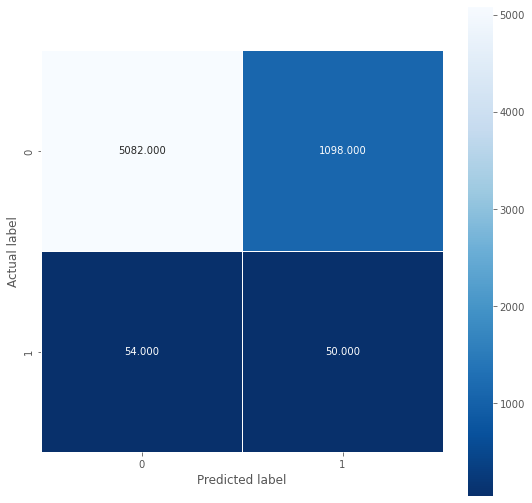

In [ ]:

x = confusion_matrix(testy, yhat3)
plt.figure(figsize=(9, 9))
sns.heatmap(x, annot=True, fmt=".3f", linewidths=.5,
            square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print(np.unique(yhat1))
print(accuracy_score(testy, yhat1))